# Force map simulation and calibration with experimenal data
Code under GNU General Public License v3 (see `LICENSE` file).<br>
Contact: A. Coulon <antoine.coulon@curie.fr> – Institut Curie, CNRS. 2021

Refer to Keizer et al. for more information (LINK TO BE ADDED).

In [1]:
from scipy import *
from matplotlib import pyplot as plt, cm
from skimage import io

import sys
sys.path.append('../../')

import MagSim as ms

## 1. Definition of the system
Repersenting the magnetic pillar as a set of finit elements (i.e. dipoles)

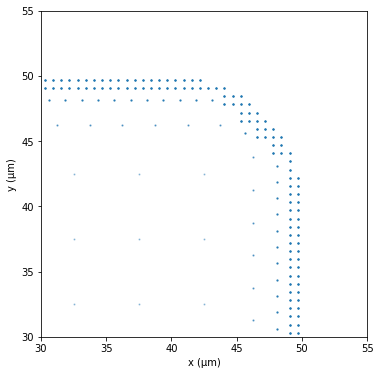

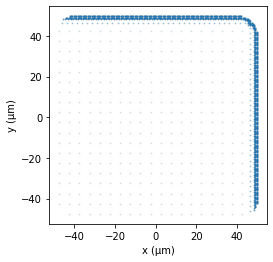

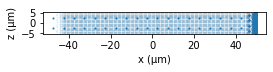

Total number of dipoles: 11472
Size of finite elements at surface: 0.625 µm


In [64]:
#== PARAMETERS =============================#

# Choose whether the representation of the pillar is
#     coarse (faster calculations –use this to run tests and to experiment)
#     or fine (slower calculations –use this to compute final force maps)
finiteElts_coarse = False

Mpillar = 3.67e5                    # Magnetization of pillar (in A/m)
                                    #   Notes: This is the (single) parameter that is adjusted during the calibration
                                    #   step using the spinning-disk data (see section 3.). The expected magnetization
                                    #   for a pillar with this composition and geometry, as measured by an independent
                                    #   approach [Toraille, Aizel et al.], are around a few 10^5 A/m.

pillarSize = r_[10,100,100]*1e-6    # Pillar size in all dimensions (ZYX in meters)
cornerRadius = 10e-6;               # Radius of curvature of pillar corners (in meters)
rotAngle = ( 45 -3. )*pi/180        # Angle of the pillar in the XY plane (in rad)

magSatMNP = 8.5e-20                 # Magnetic moment of MNPs at saturation (in A.m^2). See annex 1 below.
                                    #   Note: Only the product `magSatMNP*Mpillar` matters for the final force map,
                                    #         so since `Mpillar` is an adjusted parameter, the precise value of
                                    #         `magSatMNP` is unimportant.

temperature = 273.15 + 24.          # Temprature (in K) measured during the spinning-disk calibration experiment.

        
# Parameters for coarse discretization
nbDipoles =r_[10,100,100]//3        # Number of dipoles in all dimensions

# Parameters for fine discretization
sizeCoarse=10e-6/2;                 # Size of finite element: sizeCoarse (has to be integer fractions of pillarSize)
refinementFactors=r_[2,2,2]         # Array defining the factors of refinement of the dipole map at each iteration

#===========================================#


model=ms.Model(T=temperature,
               Bext=r_[0,sin(pi/2-rotAngle),cos(pi/2-rotAngle)]*(-0.100), # External magentic field (in Tesla).
               # Notes: 100 mT measured between the two external magnets.
               #        We are above saturation for both the pillar and the MNPs, which occur respectively at
               #        50~70 mT [Toraille, Aizel et al.] and 30 mT (as measured by VSM).
               magSatMNP=magSatMNP)

#----------- Coarse discretization (faster calculations) -----------#
if finiteElts_coarse:
    model.addBlock(orig=-pillarSize/2, size=pillarSize,
                   nbDipoles=nbDipoles, M=model.Bext/sum(model.Bext**2)**.5*Mpillar);

    ### Round corners of pillar ###
    dipoles=[];
    for dip in model.permDipoles:
        yxPos=abs(dip[0])[1:]
        distToEdge=maximum(    (yxPos-(pillarSize[-1]/2-cornerRadius)).max(-1),
                           sum((yxPos-(pillarSize[-1]/2-cornerRadius)).clip(0)**2,-1)**.5)  -cornerRadius
        if not distToEdge>=0: dipoles.append(dip)
    model.permDipoles=dipoles

    model.plotDipoleMap()
    print("Size of finite elements: %.1f x %.1f x %.1f µm"%tuple(pillarSize/nbDipoles/1e-6))

#----------- Fine discretization (slower calculations) -----------#    
else:
    M=model.Bext/sum(model.Bext**2)**.5*Mpillar;   
    model.addBlock(orig=-pillarSize/2, size=pillarSize, nbDipoles=(pillarSize/sizeCoarse).round().astype(int), M=M);

    ### Iterative refinement of the dipole map ###
    for i in range(refinementFactors.shape[0]):
        # Separate dipoles that are within a given distance to the edge ...
        dipolesCoarse=[]; dipolesFine=[]
        grainSize=sizeCoarse/prod(refinementFactors[:i])
        for dip in model.permDipoles:
            yxPos=dip[0][1:]
            distToEdge=maximum(    (yxPos-(pillarSize[-1]/2-cornerRadius)).max(-1),
                               sum((yxPos-(pillarSize[-1]/2-cornerRadius)).clip(0)**2,-1)**.5)  -cornerRadius
            if distToEdge>=-grainSize: dipolesFine  .append(dip)
            else:                      dipolesCoarse.append(dip)

        # ... and refine them.
        model.permDipoles=dipolesCoarse
        if i<refinementFactors.shape[0]-0:
            for dip in dipolesFine:
                model.addBlock(orig=dip[0]-grainSize/2, size=r_[1,1,1]*grainSize,
                               nbDipoles=r_[1,1,1]*refinementFactors[i], M=M);

    ### Round corners of pillar ###
    dipoles=[];
    for dip in model.permDipoles:
        yxPos=abs(dip[0])[1:]
        distToEdge=maximum(    (yxPos-(pillarSize[-1]/2-cornerRadius)).max(-1),
                           sum((yxPos-(pillarSize[-1]/2-cornerRadius)).clip(0)**2,-1)**.5)  -cornerRadius
        if not distToEdge>=0: dipoles.append(dip)
    model.permDipoles=dipoles


    ################
    fig=plt.figure(figsize=(6,6),dpi=72)
    tmp=array([a[0] for a in model.permDipoles])
    plt.scatter(tmp[:,2]*1e6,tmp[:,1]*1e6,marker='.',s=4,alpha=.2)
    plt.gca().set_aspect('equal', 'box'); plt.xlabel("x (µm)"); plt.ylabel("y (µm)")
    plt.xlim(30,55); plt.ylim(30,55); 
    plt.show()

    model.plotDipoleMap()
    print("Size of finite elements at surface: %.3f µm"%(sizeCoarse/prod(refinementFactors)/1e-6))


## 2. Representations of the fields

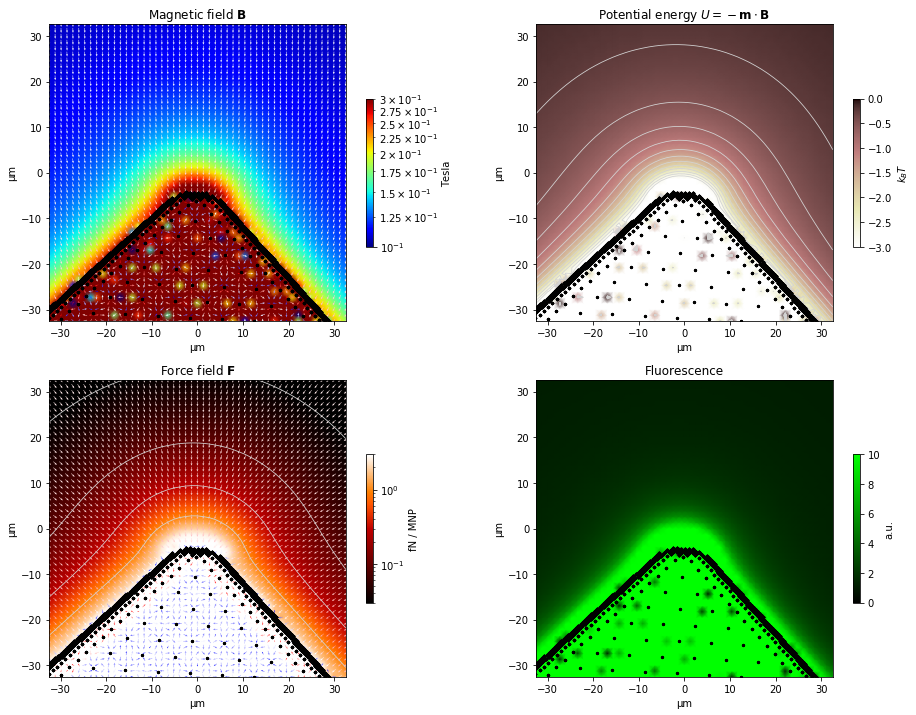

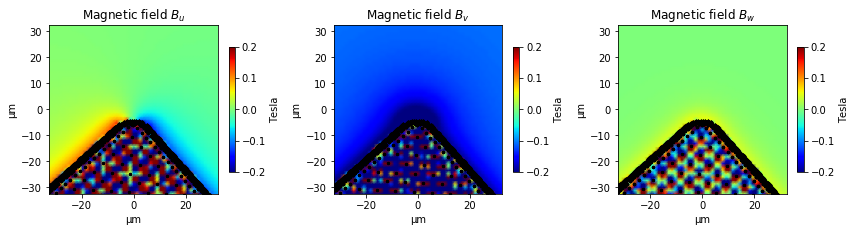

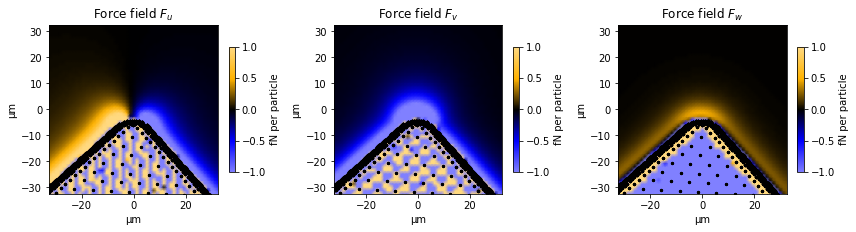

In [18]:
topView =model.calcFieldsInView(orig=r_[-5+3,50,50]*1e-6, u=r_[0,sin(-rotAngle),     cos(-rotAngle)],
                                                          v=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)],
                                uStep=.325e-6*4, vStep=.325e-6*4,
                                uRange=(-25,26), vRange=(-25,26))

topView.show(B_rangeLogVal =[log10(.1),log10(.3)],
             U_rangeVal =[-3,0], U_contours=r_[-3:0:.25],
             F_rangeLogVal =[log10(.03),log10(3.)], F_contours=[.03,.1,.3,1.],
             fluo_rangeVal =[0,10],
             fileName='fields_topView.pdf')
topView.show_B_components(rangeVal=[-.2,.2])
topView.show_F_components()


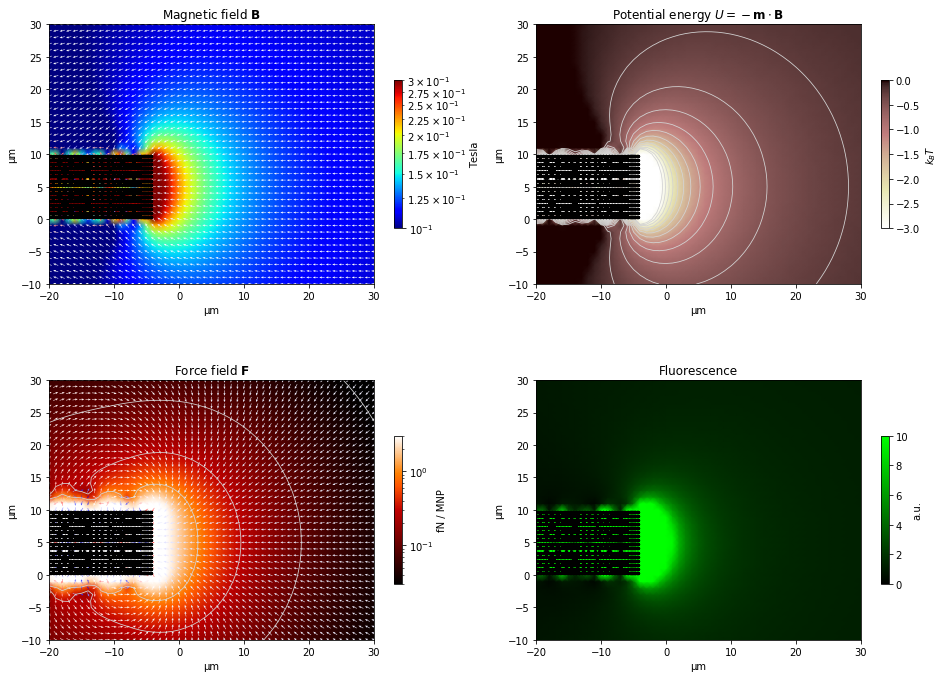

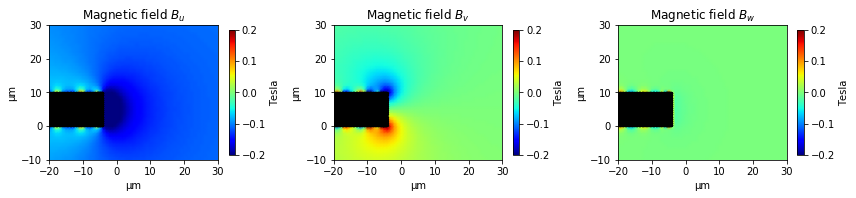

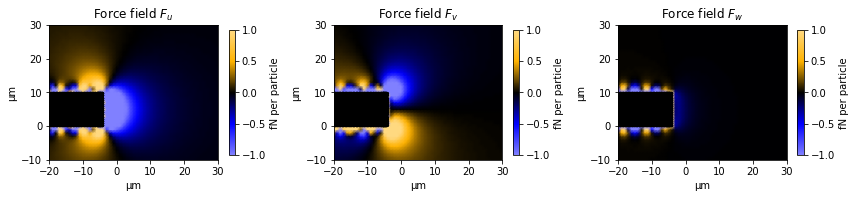

In [19]:
sideView=model.calcFieldsInView(orig=r_[-5,50.,50.]*1e-6, u=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)],
                                                          v=r_[1,0,0],
                                uStep=1.e-6, vStep=1.e-6,
                                uRange=(-20,31), vRange=(-10,31))

sideView.show(B_rangeLogVal =[log10(.1),log10(.3)],
             U_rangeVal =[-3,0], U_contours=r_[-3:0:.25],
             F_rangeLogVal =[log10(.03),log10(3.)], F_contours=[.03,.1,.3,1.],
             fluo_rangeVal =[0,10],
             fileName='fields_sideView.pdf')
sideView.show_B_components(rangeVal=[-.2,.2])
sideView.show_F_components()


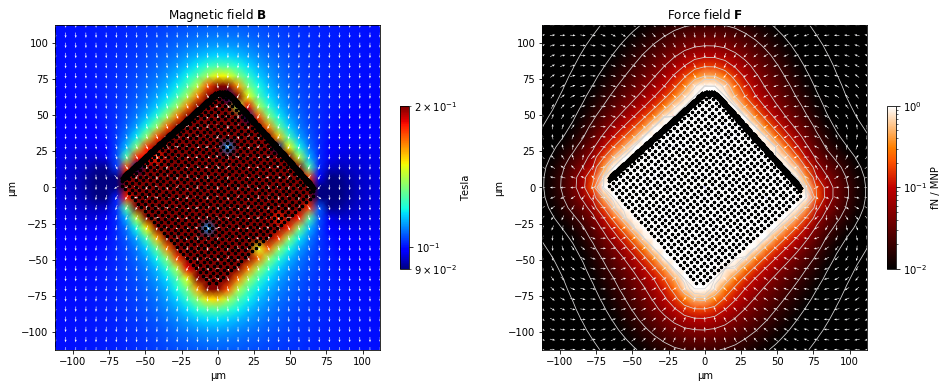

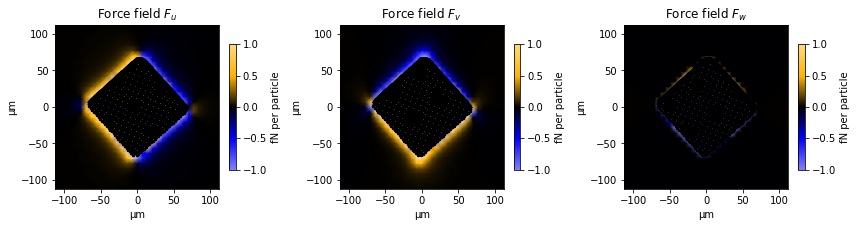

In [6]:
topViewWhole =model.calcFieldsInView(orig=r_[0,0,0], u=r_[0,sin(-rotAngle), cos(-rotAngle)], v=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)], uStep=7.e-6, vStep=7.e-6, uRange=(-16,17), vRange=(-16,17))
fig=plt.figure(figsize=(16,6),dpi=72)
fig.add_subplot(121); topViewWhole.show_B(rangeLogVal =[log10(.09),log10(.2)],contours=[.03],fig=fig)
fig.add_subplot(122); topViewWhole.show_F(rangeLogVal =[log10(.01),log10(1.)],contours=[.005,.01,.02,.05,.1,.2,.5,1,2,5],fig=fig)
plt.savefig('fields_topViewWhole.pdf')
topViewWhole.show_F_components()


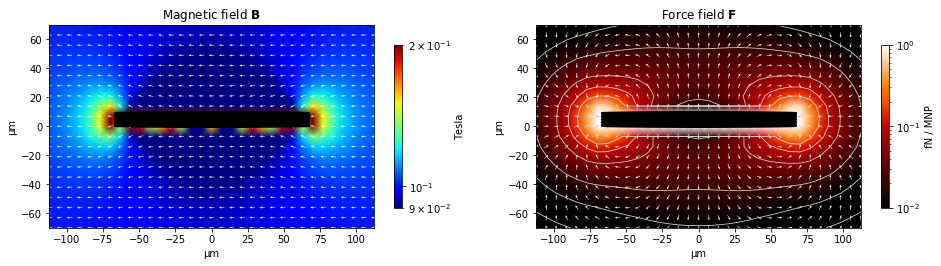

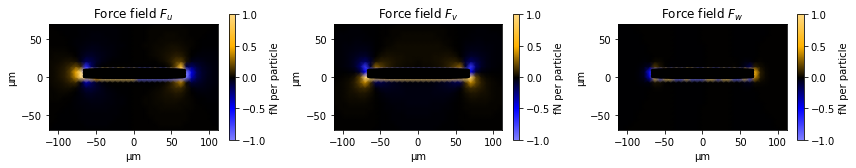

In [14]:
sideViewWhole =model.calcFieldsInView(orig=r_[-5,0.,0.]*1e-6, u=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)], v=r_[1,0,0], uStep=7.e-6, vStep=7.e-6, uRange=(-16,17), vRange=(-10,11))
fig=plt.figure(figsize=(16,6),dpi=72)
fig.add_subplot(121); sideViewWhole.show_B(rangeLogVal =[log10(.09),log10(.2)],fig=fig)
fig.add_subplot(122); sideViewWhole.show_F(rangeLogVal =[log10(.01),log10(1.)],contours=[.005,.01,.02,.05,.1,.2],fig=fig)
plt.savefig('fields_sideViewWhole.pdf')
sideViewWhole.show_F_components()


----
## 3. Calibration with experimental data

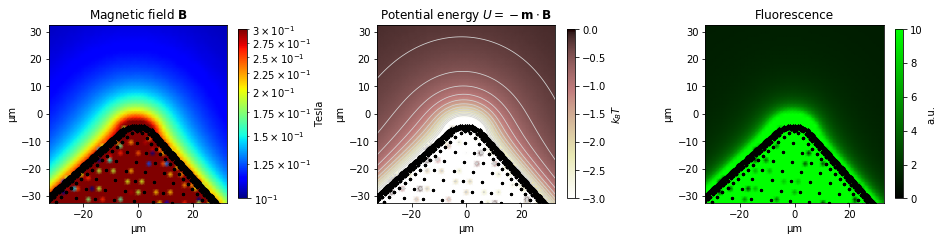

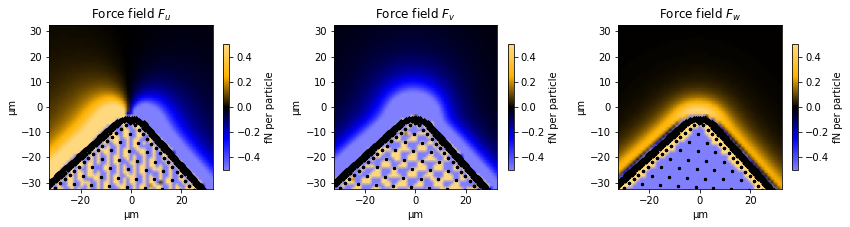

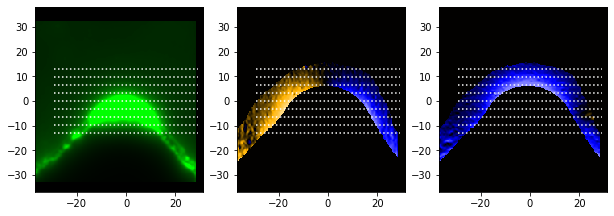

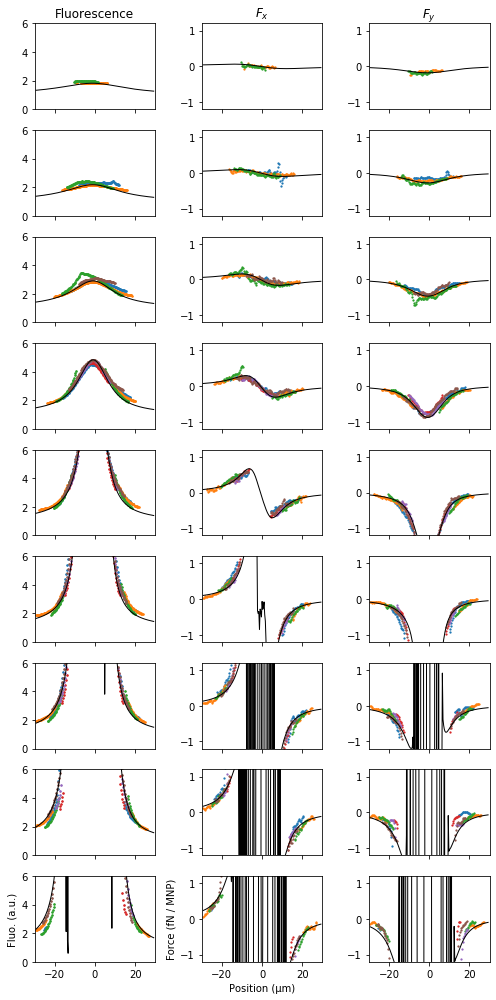

In [50]:
#== PARAMETERS =============================#

# Spining disk data
#   Dimensions: Field, Channel, Z, Y, X
#   Channels: Fx, Fy, Fz, fluo, mask, corner marker
fname="20190724_array1_ferritinJuly24_batch_1in10fromdil_allPillars_z1cov_Fxyz_mask_reg7.tif"
try:
    im=io.imread(fname).swapaxes(1,2)
except FileNotFoundError:
    raise SystemExit('To run section 3. of this notebook, you will need to download file `%s` from https://zenodo.org/deposit/4627062'%fname)

# Voxel size
dxy=0.325e-6 # (in meters)
dz=1.0e-6    # (in meters)

# Z position to use for calibration
zCoo=7*dz    # (in meters)

# Coordinates of lines where model and data are compared (i.e. dotted lines in the plots below)
#   These coordinates are relative to the corner marker on the last channel of the image file.
linesCoo=[array([[ 40*dxy, -90*dxy],[ 40*dxy, 90*dxy]]),
          array([[ 30*dxy, -90*dxy],[ 30*dxy, 90*dxy]]),
          array([[ 20*dxy, -90*dxy],[ 20*dxy, 90*dxy]]),
          array([[ 10*dxy, -90*dxy],[ 10*dxy, 90*dxy]]),
          array([[  0*dxy, -90*dxy],[  0*dxy, 90*dxy]]),
          array([[-10*dxy, -90*dxy],[-10*dxy, 90*dxy]]),
          array([[-20*dxy, -90*dxy],[-20*dxy, 90*dxy]]),
          array([[-30*dxy, -90*dxy],[-30*dxy, 90*dxy]]),
          array([[-40*dxy, -90*dxy],[-40*dxy, 90*dxy]]),] # [[start], [end]] (YX in meters)

fluoAUrescale = [4.,1.8,30.,14.5,11,17.3] # Rescaling of fluorescence 'arbitrary units' for each pillar.

#===========================================#


#--- Conversions --------------------------------------------------------------#
cornerCooPx=array(where(im[0,-1])).T[0] # ZYX coordinates (in pixels) of the corner marker (i.e. where the corner of
                                        # the pillar would be if it was not rounded)

# Convert real coorinates (in meters and relative to the corner marker) into absolute image coordinates (in pixel)
zCooPx    =cornerCooPx[0]  +int(round(zCoo/dz))
linesCooPx=[cornerCooPx[1:]+r_[-1,1]*(lc/dxy).round().astype(int) for lc in linesCoo]


#--- Plot maps ----------------------------------------------------------------#

# simulated maps
fig,ax=plt.subplots(1,3,figsize=(13.2,5));
plt.sca(ax[0]); topView.show_B(fig=fig, rangeLogVal =[log10(.1),log10(.3)],showArrows=False)
plt.sca(ax[1]); topView.show_U(fig=fig, rangeVal =[-3,0], contours=r_[-3:0:.25])
plt.sca(ax[2]); topView.show_fluo(fig=fig, rangeVal=[0,10])
plt.tight_layout()
plt.savefig("compare_model_fluo.png",dpi=200)

topView.show_F_components(rangeVal=[-.5,.5],fileName="compare_model_F.pdf")

# experimental maps
#for field in r_[:im.shape[0]]:
for field in [1]:
    fig,ax=plt.subplots(1,3,figsize=(10.25,4.5))
    extent=r_[r_[0,im.shape[-1]]-cornerCooPx[-1]-.5, r_[0,im.shape[-2]]-cornerCooPx[-2]-.5, ]*dxy*1e6
    plt.sca(ax[0]);
    plt.imshow(im[field,3,zCooPx] *fluoAUrescale[field]   ,cmap=ms.cmap_BkGn,   extent=extent); plt.clim(0,10);
    plt.sca(ax[1]);
    plt.imshow(im[field,0,zCooPx] *im[field,4,zCooPx]/255 ,cmap=ms.cmap_BlBkOr, extent=extent); plt.clim(-.5,.5);
    plt.sca(ax[2]);
    plt.imshow(im[field,1,zCooPx] *im[field,4,zCooPx]/255 ,cmap=ms.cmap_BlBkOr, extent=extent); plt.clim(-.5,.5);
    for ax_ in ax:
        for lc in linesCoo: ax_.plot(lc[:,1]*1e6,lc[:,0]*1e6,c='w',ls=':')
    plt.savefig("compare_spinning.pdf")


#--- Line plots ---------------------------------------------------------------#
linesModel=[model.calcFieldsInView(orig=r_[-5,50,50]*1e-6+r_[zCoo,0,0],
                                   u=r_[0,sin(-rotAngle),     cos(-rotAngle)],
                                   v=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)],
                                   uStep=dxy, vStep=dxy,
                                   uRange=(int(round(lc[0][1]/dxy)),int(round(lc[1][1]/dxy))+1),
                                   vRange=(int(round(lc[0][0]/dxy)),int(round(lc[1][0]/dxy))+1))
                                                                                          for lc  in linesCoo]
linesData=[ im[:, :, zCooPx, min(lcp[:,0]):max(lcp[:,0])+1, lcp[0,1]:lcp[1,1]+1]  for lcp in linesCooPx]

fig,ax=plt.subplots(len(linesCoo),3,sharex=True,figsize=(7,14))
for i,(lm,ld) in enumerate(zip(linesModel,linesData)):
    ax_=ax[i]
    for field in range(im.shape[0]):
        wh=where(ld[field,4].flatten())
        ax_[0].scatter(lm.uCoo[wh]*1e6,ld[field,3].flatten()[wh]*fluoAUrescale[field],marker='.',s=10)
        ax_[1].scatter(lm.uCoo[wh]*1e6,ld[field,0].flatten()[wh],marker='.',s=6)
        ax_[2].scatter(lm.uCoo[wh]*1e6,ld[field,1].flatten()[wh],marker='.',s=6)
    ax_[0].plot(lm.uCoo*1e6,lm.fluo.flatten(),         c='k',lw=1); ax_[0].set_ylim(0,6)
    ax_[1].plot(lm.uCoo*1e6,lm.F[:,:,2].flatten()*1e15,c='k',lw=1); ax_[1].set_ylim(-1.2,1.2)
    ax_[2].plot(lm.uCoo*1e6,lm.F[:,:,1].flatten()*1e15,c='k',lw=1); ax_[2].set_ylim(-1.2,1.2)
ax[0,0].set_title("Fluorescence"); ax[0,1].set_title("$F_x$"); ax[0,2].set_title("$F_y$")
ax[-1,1].set_xlabel("Position (µm)"); ax[-1,1].set_xlim(-30,30)
ax[-1,0].set_ylabel("Fluo. (a.u.)"); ax[-1,1].set_ylabel("Force (fN / MNP)");
plt.tight_layout()
plt.savefig("compare_lines.pdf")



### Finding the value of `Mpillar` the fit bests the data:
Run this only once:

In [150]:
res=[] # Initialize list

Then, for each value of `Mpillar` you want to assess, repeat the following:
- Run the cell of code under __Definition of the system__ with the value of `Mpillar` you want.
- Run the cell of code under __Calibration with experimental data__.
- Run the cell below to calculate the mean square residuals between the model and the data.

In [170]:
# Calculate and record the mean square resitudals
lsq=[]
for lm,ld in zip(linesModel,linesData):     # all the line plots
    for i in r_[:2]:                        # Fx and Fy
        for field in range(im.shape[0]):    # All pillars
            wh=where(ld[field,4].flatten()) # mask
            lsq.extend(list((ld[field,i].flatten() - lm.F[:,:,2-i].flatten()*1e15)[wh]**2)) # Square residuals

res.append([Mpillar,mean(lsq)])

Finally, run this cell to plot the graph and find the best value for `Mpillar` and the error in the force.

Best value of magentization: 3.67e+05 A/m
S.d. of force residuals:     0.094 fN/MNP


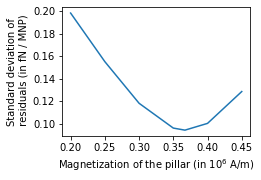

In [207]:
plt.figure(figsize=(3.7,2.6))
plt.plot(array(res)[:,0]/1e6,array(res)[:,1]**.5)
plt.xlabel("Magnetization of the pillar (in 10$^6$ A/m)"); plt.ylabel("Standard deviation of\n residuals (in fN / MNP)"); 
plt.tight_layout(); plt.savefig('Mpillar_optim.pdf')

print("Best value of magentization: %.2e A/m"%res[argmin(array(res)[:,1])][0])
print("S.d. of force residuals:     %.3f fN/MNP"%min(array(res)[:,1]**.5))

----
## 4. Generate force map (.tif file)

First, execute section 1 to setup the parameters and create the model.

Note: Computation time is about 1 µs per dipole, per pixel(/voxel) in map.

In [63]:
## Single z-plane

uRange=r_[-104:105:13]; uRange[-1]+=1
vRange=r_[-104,105];
uStep=.125e-6*5; vStep=.125e-6*5;

z=3

forceMap=concatenate([(print("Computing map %d/%i..."%(i+1,uRange.shape[0]-1)), model.calcFieldsInView(orig=r_[-5+z,50,50]*1e-6, u=r_[0,sin(-rotAngle), cos(-rotAngle)], v=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)], uStep=uStep, vStep=vStep, uRange=uRange[[i,i+1]], vRange=vRange).F)[1]
                      for i in range(uRange.shape[0]-1)])[:,::-1].T
print("Done.")

from skimage import io
io.imsave('forceMap.tif',(forceMap[[2,1,0,2,1,0]]/1e-15).astype(float32))


Computing map 1/16...
Computing map 2/16...
Computing map 3/16...
Computing map 4/16...
Computing map 5/16...
Computing map 6/16...
Computing map 7/16...
Computing map 8/16...
Computing map 9/16...
Computing map 10/16...
Computing map 11/16...
Computing map 12/16...
Computing map 13/16...
Computing map 14/16...
Computing map 15/16...
Computing map 16/16...
Done.


In [6]:
## Multiple z-planes

uRange=r_[-104:105:13]; uRange[-1]+=1
vRange=r_[-104,105];
uStep=.125e-6*5; vStep=.125e-6*5;

forceMapStack=array([concatenate([(print("Computing map: z=%d/6, subregion=%d/%i..."%(z+1,i+1,uRange.shape[0]-1)), model.calcFieldsInView(orig=r_[-5+z,50,50]*1e-6, u=r_[0,-1,1], v=r_[0,1,1], uStep=uStep, vStep=vStep, uRange=uRange[[i,i+1]], vRange=vRange).F)[1] for i in range(uRange.shape[0]-1)])[:,::-1]
                     for z in r_[0:6]]).T
print("Done.")

forceMapStackMirror=r_[forceMapStack.T,forceMapStack.T[:-1][::-1]*r_[-1,1,1]].T
from skimage import io
io.imsave('forceMapStack.tif',(moveaxis(forceMapStackMirror,-1,1)[[2,1,0]]/1e-15).astype(float32))


Computing map: z=1/6, subregion=1/16...
Computing map: z=1/6, subregion=2/16...
Computing map: z=1/6, subregion=3/16...
Computing map: z=1/6, subregion=4/16...
Computing map: z=1/6, subregion=5/16...
Computing map: z=1/6, subregion=6/16...
Computing map: z=1/6, subregion=7/16...
Computing map: z=1/6, subregion=8/16...
Computing map: z=1/6, subregion=9/16...
Computing map: z=1/6, subregion=10/16...
Computing map: z=1/6, subregion=11/16...
Computing map: z=1/6, subregion=12/16...
Computing map: z=1/6, subregion=13/16...
Computing map: z=1/6, subregion=14/16...
Computing map: z=1/6, subregion=15/16...
Computing map: z=1/6, subregion=16/16...
Computing map: z=2/6, subregion=1/16...
Computing map: z=2/6, subregion=2/16...
Computing map: z=2/6, subregion=3/16...
Computing map: z=2/6, subregion=4/16...
Computing map: z=2/6, subregion=5/16...
Computing map: z=2/6, subregion=6/16...
Computing map: z=2/6, subregion=7/16...
Computing map: z=2/6, subregion=8/16...
Computing map: z=2/6, subregion=9

-----
## 5. Make plots for main figure
First, execute section 1 to setup the parameters and create the model.

PDF file to be used for contour lines:

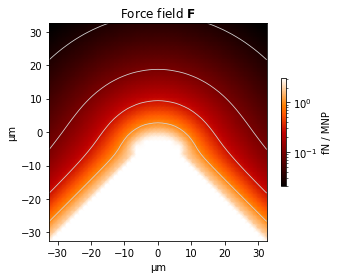

In [52]:
mainFig1=model.calcFieldsInView(orig=r_[-5+3,50,50]*1e-6, u=r_[0,sin(-rotAngle),     cos(-rotAngle)],
                                                          v=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)],
                                uStep=.325e-6*4, vStep=.325e-6*4,
                                uRange=(-25,26), vRange=(-25,26))

fig=plt.figure(figsize=(5,4),dpi=72)
mainFig1.show_F(contours=[0.03,.1,.3,1],showArrows=False,showDipoleMap=False,rangeLogVal=[-1.7,.5],cmap=cm.gist_heat,fig=fig);
plt.savefig('fig1_force_field_contour.pdf')


PNG file to be used for heatmap:

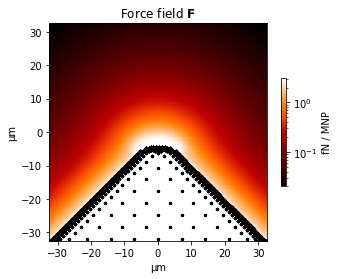

In [53]:
fig=plt.figure(figsize=(5,4),dpi=72)
mainFig1.show_F(showArrows=False,rangeLogVal=[-1.7,.5],cmap=cm.gist_heat,fig=fig);
plt.savefig('fig1_force_field_map.png',dpi=300)


PDF file to be used for arrows:

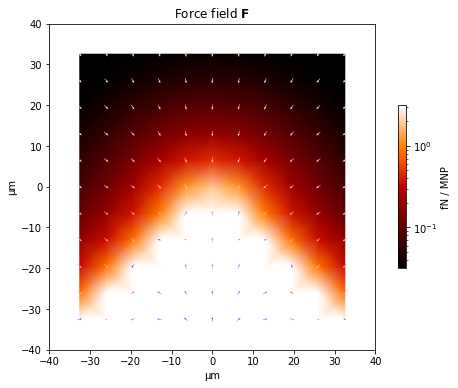

In [54]:
mainFig2=model.calcFieldsInView(orig=r_[-5+3,50,50]*1e-6, u=r_[0,sin(-rotAngle),     cos(-rotAngle)],
                                                          v=r_[0,sin(-rotAngle+pi/2),cos(-rotAngle+pi/2)],
                                uStep=.325e-6*20, vStep=.325e-6*20,
                                uRange=(-5,6), vRange=(-5,6))

fig=plt.figure(figsize=(8,6),dpi=72)
mainFig2.show_F(rangeLogVal=[-1.5,.5],showDipoleMap=False,fig=fig); plt.xlim(-40,40); plt.ylim(-40,40)
plt.savefig('fig1_force_field_arrows.pdf')

---
## Annexes

### Annex 1: Magnetic moments at saturation for single MNPs

In [5]:
NA = 6.022e23 # Avogadro's number (in 1/mol)

# Ferritin batch H 
c_MNP = 1.605e-6             # Concentration of ferritin (in M) used for VSM measurement. (Measured from calibrated Bradford assay)
M_sat_emuL = 1.67e-3 / 20e-6 # Magentic moment at saturation (in emu/L), from VSM measurement on 20µL of solution
magSatMNP_H = M_sat_emuL * 1e-3 /(c_MNP*NA) # A.m^2/MNP
print("Ferritin batch H: %.3e A.m^2/MNP"%magSatMNP_H)

# Ferritin batch J
c_MNP = 1.592e-6             # Concentration of ferritin (in M) used for VSM measurement. (Measured from calibrated Bradford assay)
M_sat_emuL = 1.63e-3 / 20e-6 # Magentic moment at saturation(in emu/L), from VSM measurement on 20µL of solution
magSatMNP_J = M_sat_emuL * 1e-3 /(c_MNP*NA) # A.m^2/MNP
print("Ferritin batch J: %.3e A.m^2/MNP"%magSatMNP_J)


Ferritin batch H: 8.639e-20 A.m^2/MNP
Ferritin batch J: 8.501e-20 A.m^2/MNP
